# SLEAP Demo

*By Louise Xu*

SLEAP is a pose estimation application that provides manual video annotation GUI. It requires some manual annotation, and trains a machine learning model to learn to label video frames. 

## Set up SLEAP

Instructions to install SLEAP are available at their [website](https://sleap.ai/develop/installation.html). The README document contains some guidance on how to install SLEAP on a Windows 10 machine with Conda. 

One important note is that SLEAP only allows NVIDIA GPUs, so other GPUs like the Intel Iris XE GPU on my laptop would not compatible. SLEAP can still be run on laptops with no GPU or incompatible GPUs, but training would be much slower (1-2 min vs 20 min training time). This shouldn't be an issue with AppStream since it provides NVIDIA GPU services.  

## Annotate the video in GUI

### 1. Import the video

The user will add animal videos from the folder that will be analyzed. 

Sample videos are available at [SLEAP Github](https://github.com/talmolab/sleap/tree/develop/tests/data/videos), this demo uses the [video with two insects](https://github.com/talmolab/sleap/blob/develop/tests/data/videos/centered_pair_small.mp4). 

### 2. Create the skeleton

The user will define which features of the animal will be investigated and create an animal skeleton. 

**Nodes** can be created manually to represent differnt body parts, and **Edges** between nodes can also be added. 

### 3. Select initial frames

The user will select some initial frames which would be annotated manually by the user. 

The user can either pick their own frames to annotate, or use suggested frames by SLEAP. This demo uses 20 evenly-spaced frames suggested by SLEAP using the "stride" sampling method. SLEAP also offers a "random" sampling method as well as other suggestion methods, such as based on image features. The "prev" and "next" buttons can be used to navigate between suggested frames.  

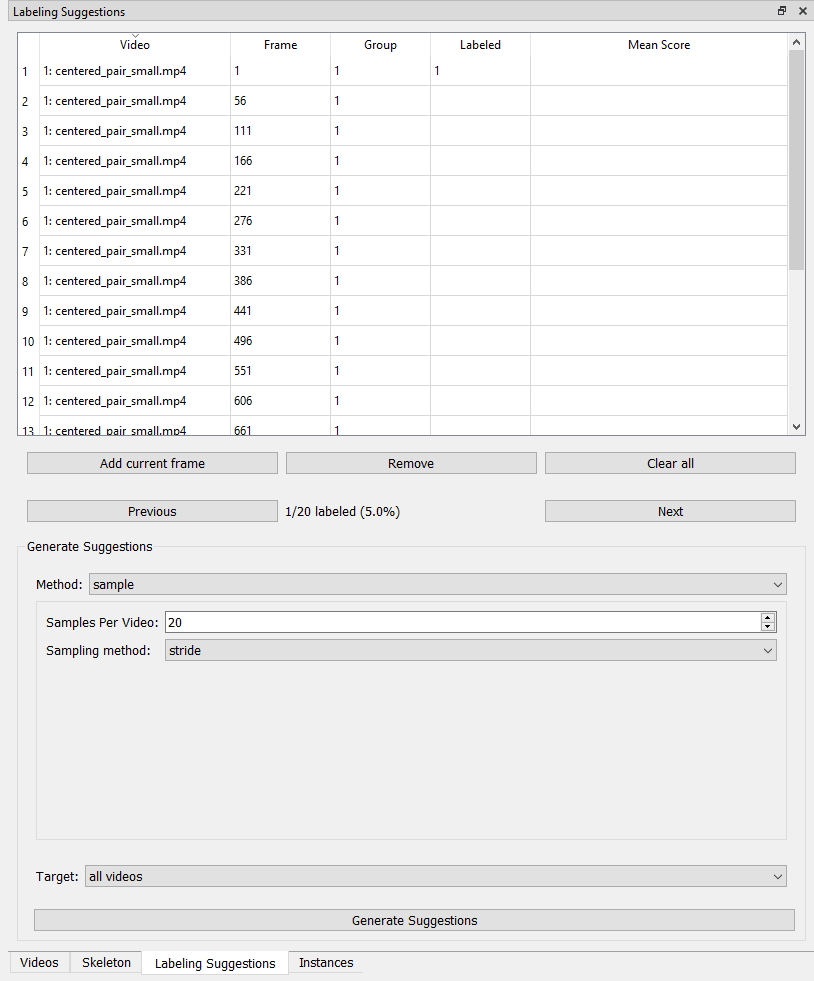

Notice that the selected frame will appear as blue (suggested) or black (manually selected) slots in the seekbar under the video. 

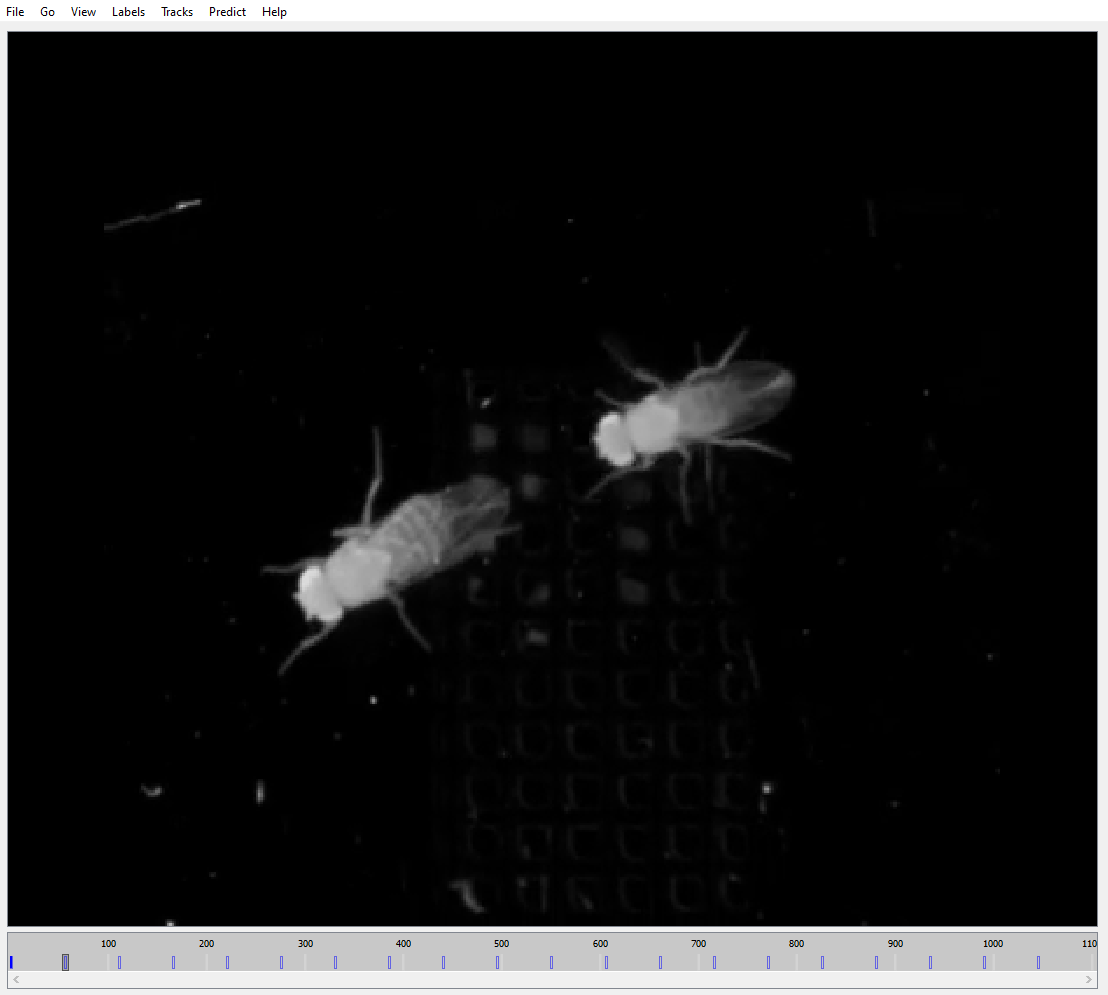

### 4. Label instances in selected frames

The user will labels instances corresponding to animals in each selected frame.

For each frame, the user can add an instance of the pre-defined skeleton, and move the nodes to appropriate positions using the mouse. The nodes would initially appear in red, and turn green after it has been moved. 

For multiple-animal videos, the user can choose to add multiple instances for each frame. At this stage, there is no need to be consistent about which animal you label with which instance. The user should only be concerned with positioning the nodes correctly in each instance. The user will ensure that the instances are consistent across frames in the final tracking and track proofreading stage.



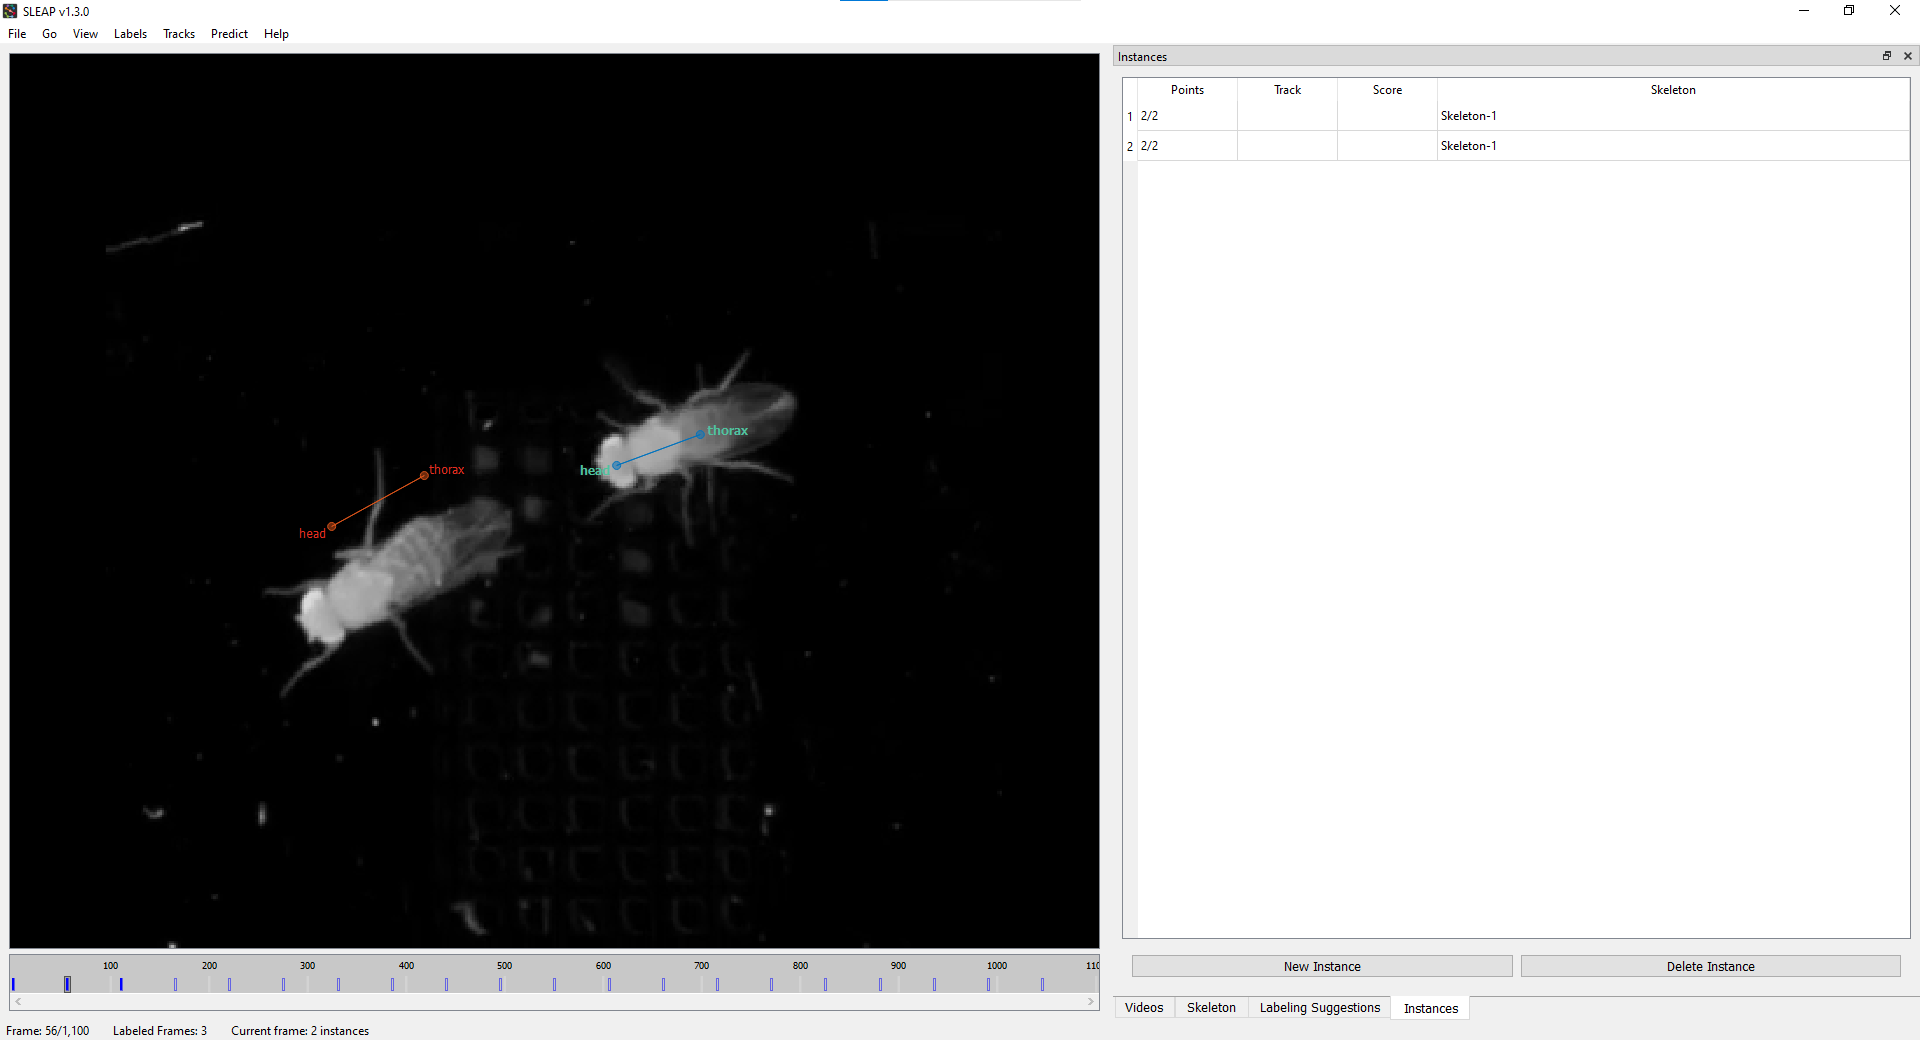

### 5. Train model on labeled frames

The user will train a machine learning model to learn how to label instances in each frame using the initial user-labeled frames. 

Click "Predict - Run Training" to configure the training pipeline. This demo uses mostly the default settings except for choosing to run prediction on "random frames (19 total)" at this phase. These predictions can be used to assess how the trained model performs, as well as make make corrections on these predictions to be put in the next training phase (since it is easier to correct a label than to make a new label). 


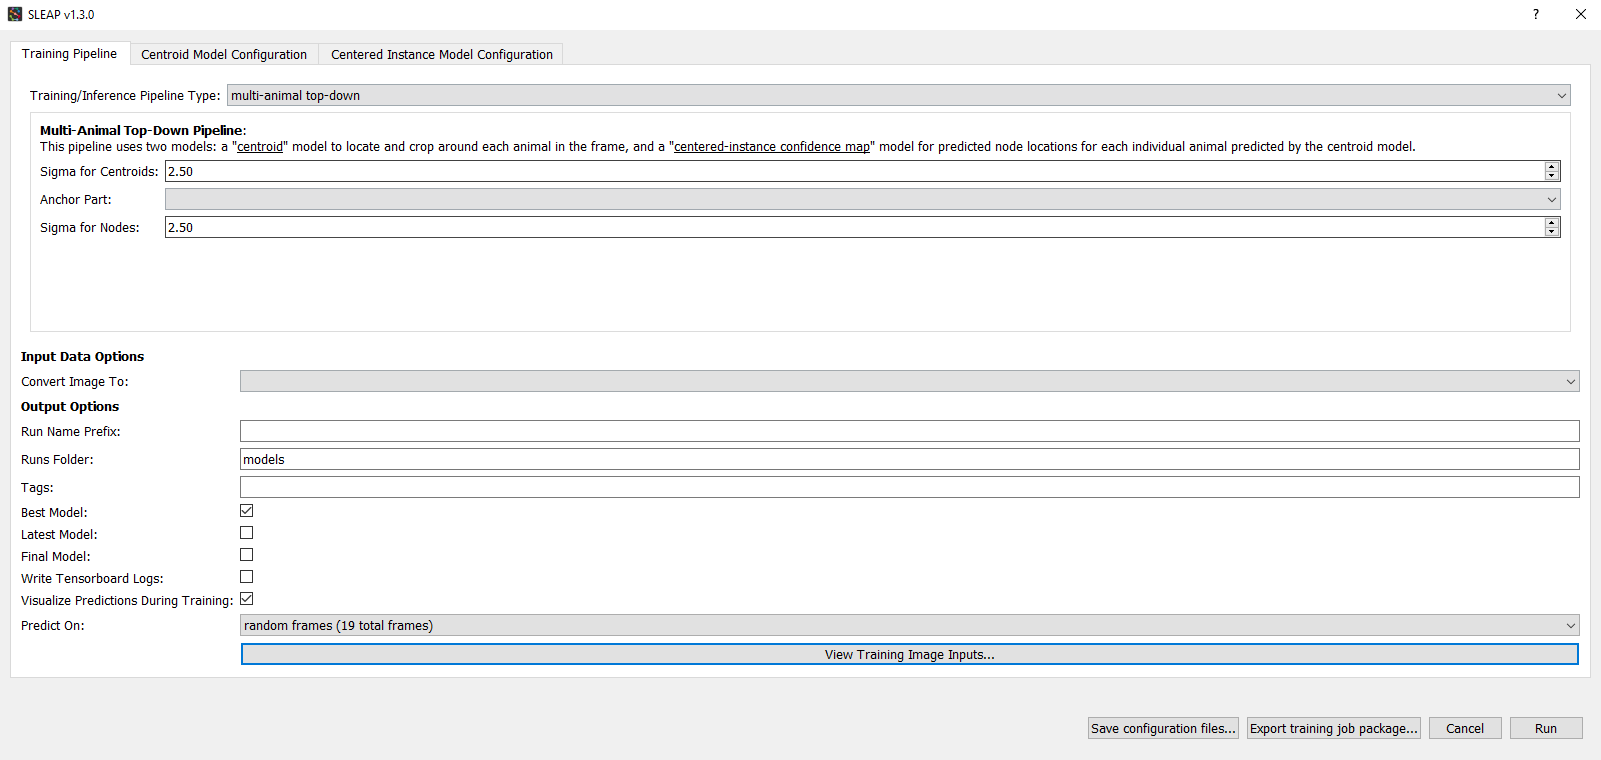

For the multi-animal top-down pipline, two models would be trained: first a "centroid" model that locates and crops around each animal in the frame, then a "centered instance confidence map" that predicts node locations for each animal predicted by the centroid model. In this demo, the training is stopped early at around epoch 10 for centroid model and epoch 20 for centered instance model. The following screenshot shows the training in-progress and how the loss gradually decreases across epochs. 

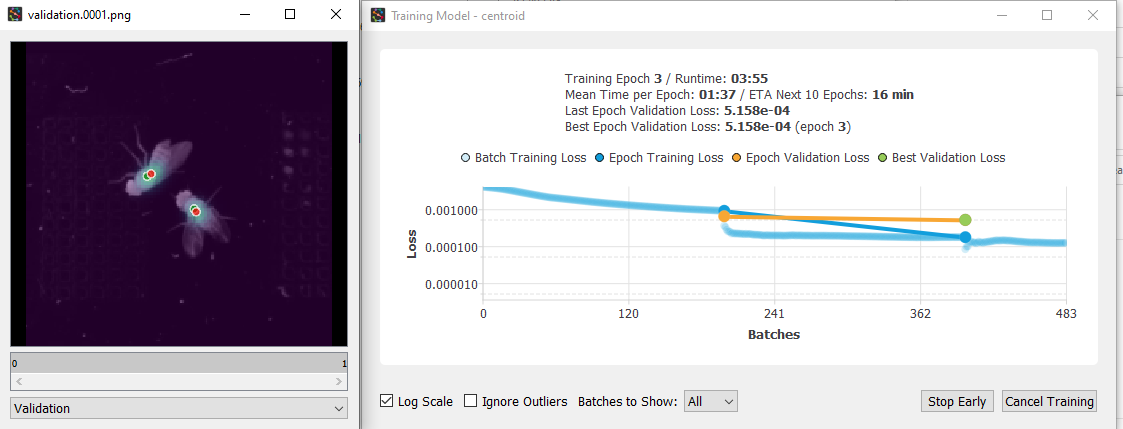

Alternatively, the user may also choose to run training and prediction separately. In the training configuration, choose to prediction on "None". After training is completed, click "Predict - Run Inference" and specify prediction on "random frames (20 total)". 

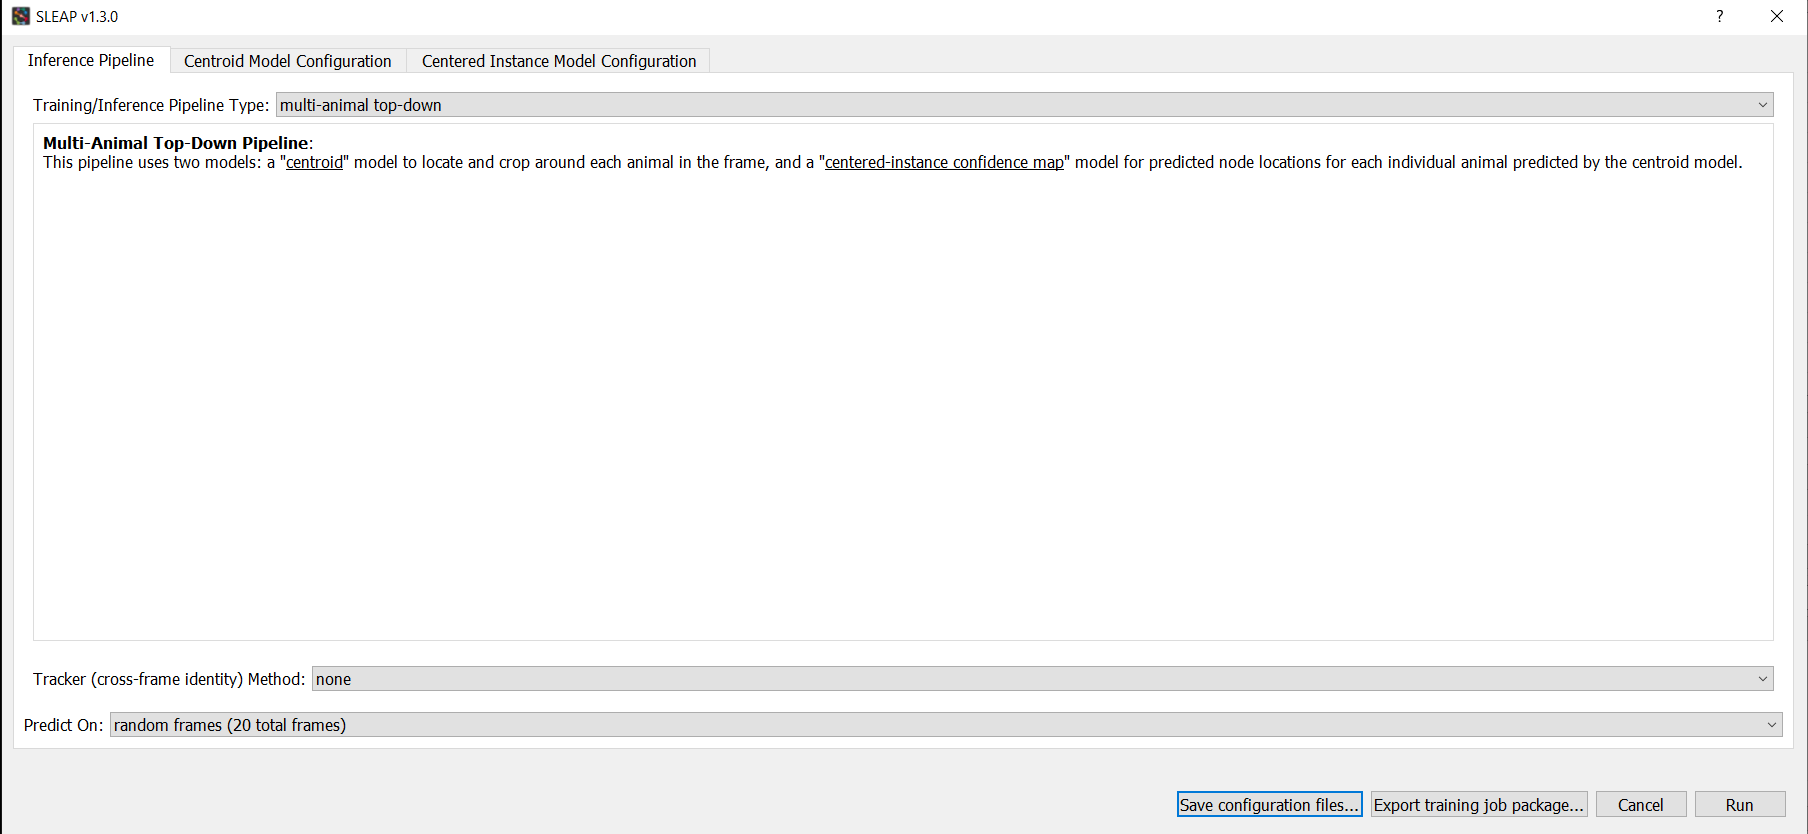

By default, the inference pipeline uses the most recent trained model, but the user can use the dropdown menu to select other trained models if desired. 

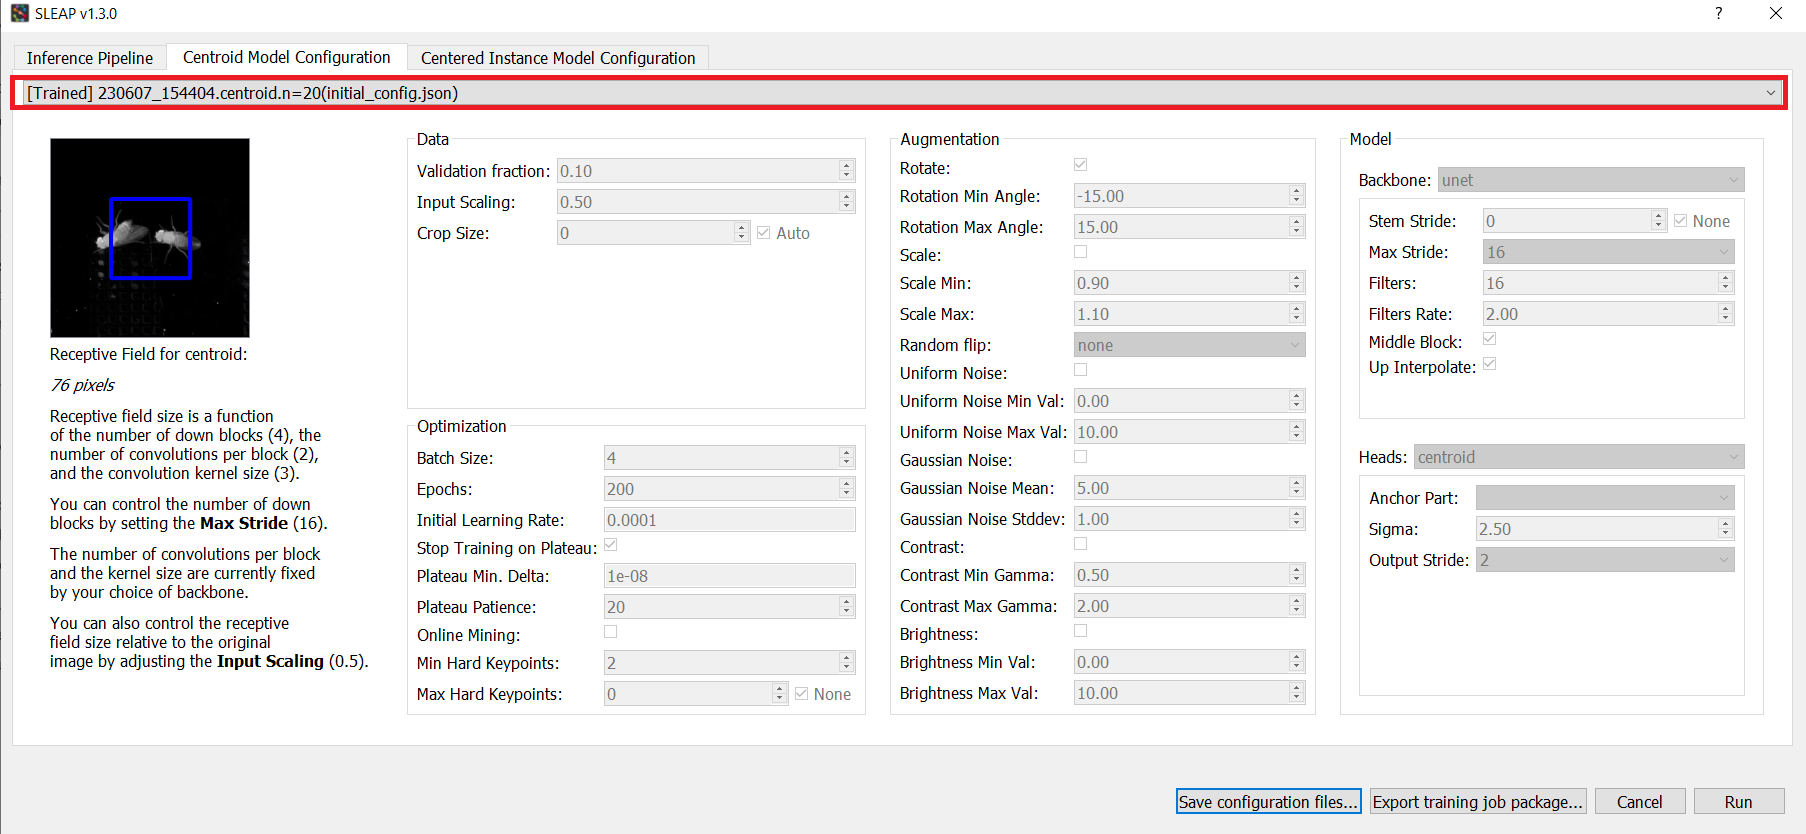

For this demo, we can see that the initial predictions on the new random frames are represented by black lines in the seekbar.

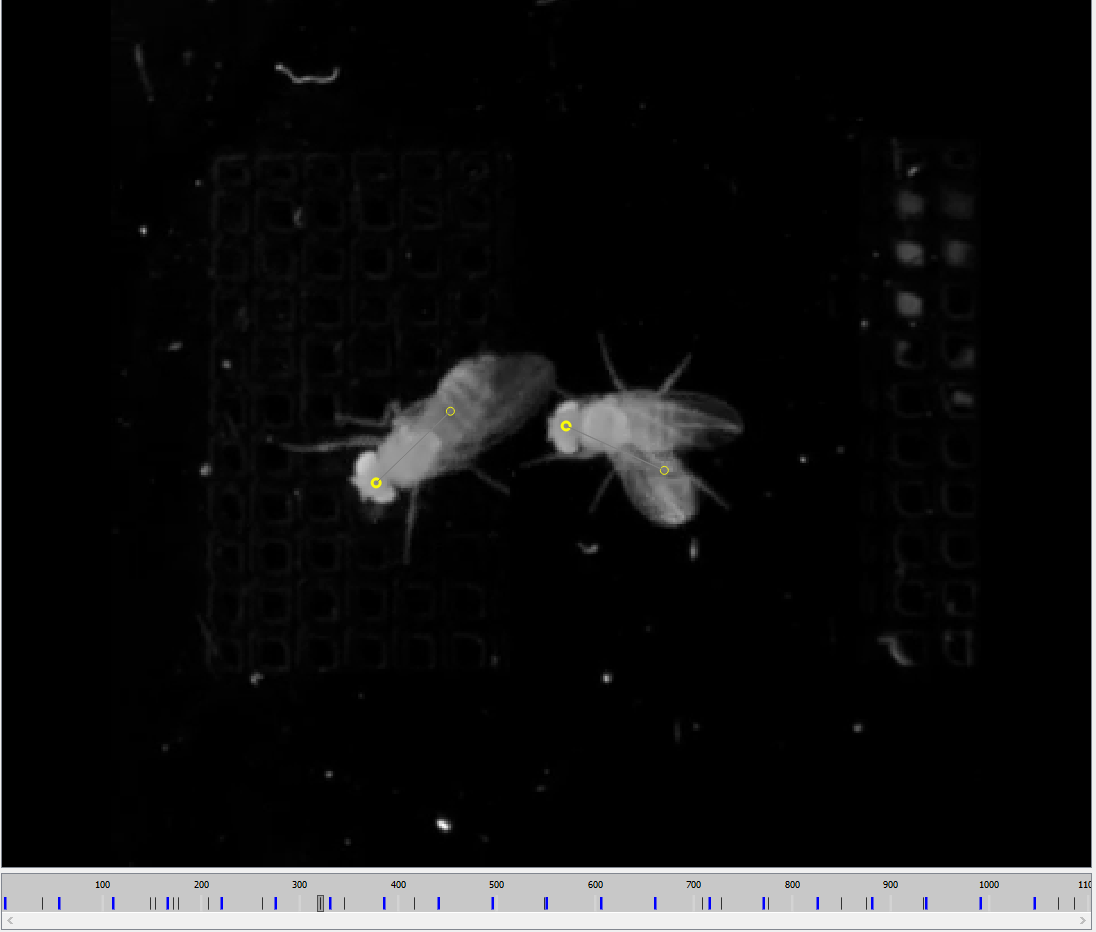

### 6. Refine model via Prediction assisted labeling and Repeated training

After getting the initial predictions, the user enters a human-in-the-loop training cycle, where the user trains a new model, predicts on more frames, corrects those predictions, and repeats. The goal of this step is to get a model that gives accurate pose predictions on individual frames. 

Every time the model is trained and some frames have been predicted, the user can review the predicted instances and correct them if necessary. Predicted instances will not be used for future model training unless they have been corrected in the GUI. After all predicted instances have been reviewed and refined, the user can repeat the training process on new random frames. 

**Refining a predicted instance**

Predicted instances are displayed in grey with <span style='color:gold'>yellow</span> nodes. Double clicking on a predicted instance will convert it into a regular editable instance with <span style='color:red'>red</span> nodes. Nodes that are moved will turn <span style='color:darkturquoise'>green</span> to differentiate from nodes that have not been moved. 

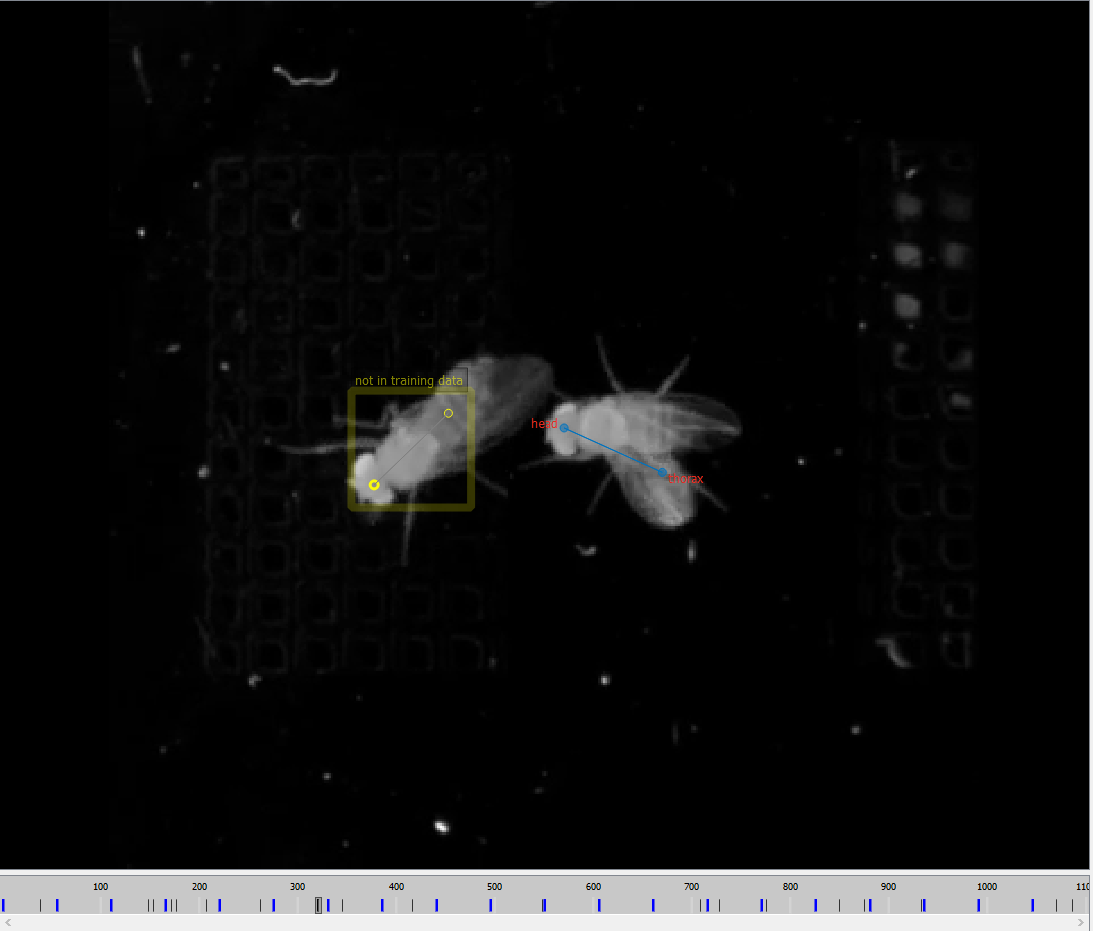

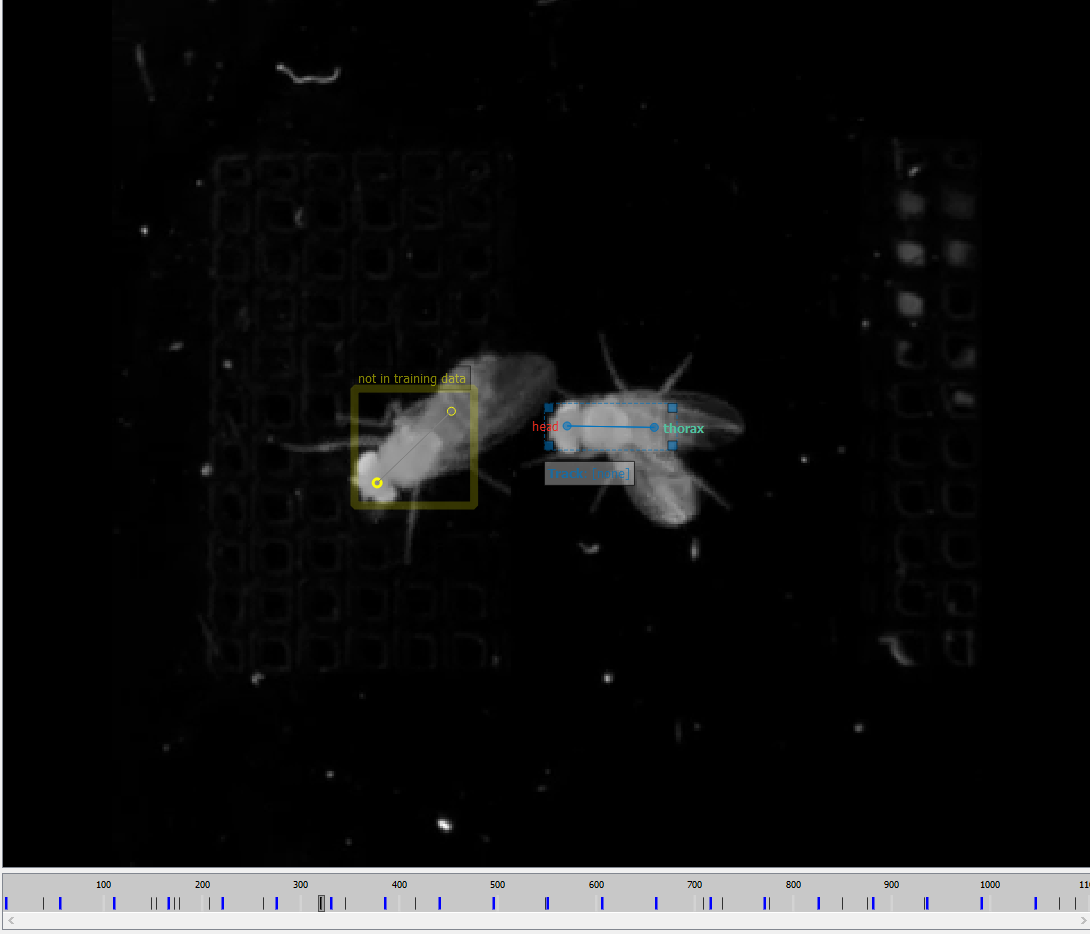

### 7. Track poses with trained model 

Once the user is satisfied with the prediction accuracy, the user is ready to use the trained model to predict on more frames (i.e. the entire video) and track the poses of interested identities.

In the inference pipeline, the user can set up the tracker for tracking distinct instance identities over video frames. 
The tracker will go through the predictions frame by frame and try to match instances on frame N to candidates which already have track identities assigned. (I have not figured out how to add tracks to already completed inferences.)

Click "Predict - Run Inference", specify prediction on "entire video", and select a tracker method "simple". This demo tracks two insects, so the "Target Number of Instances Per Frame" is set to 2 and "Cull to Target Instance Count" is enabled to remove instances over this number. This step is optional and will not make a huge difference for this simple demo. 

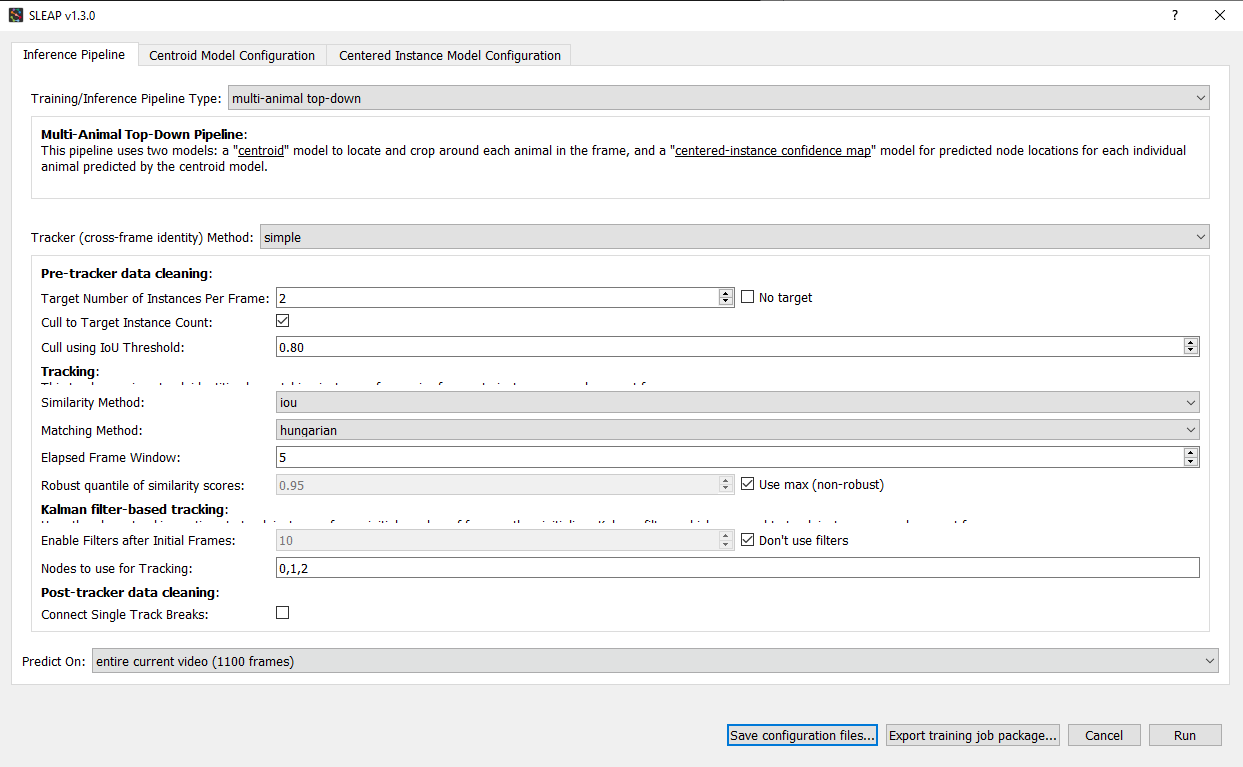

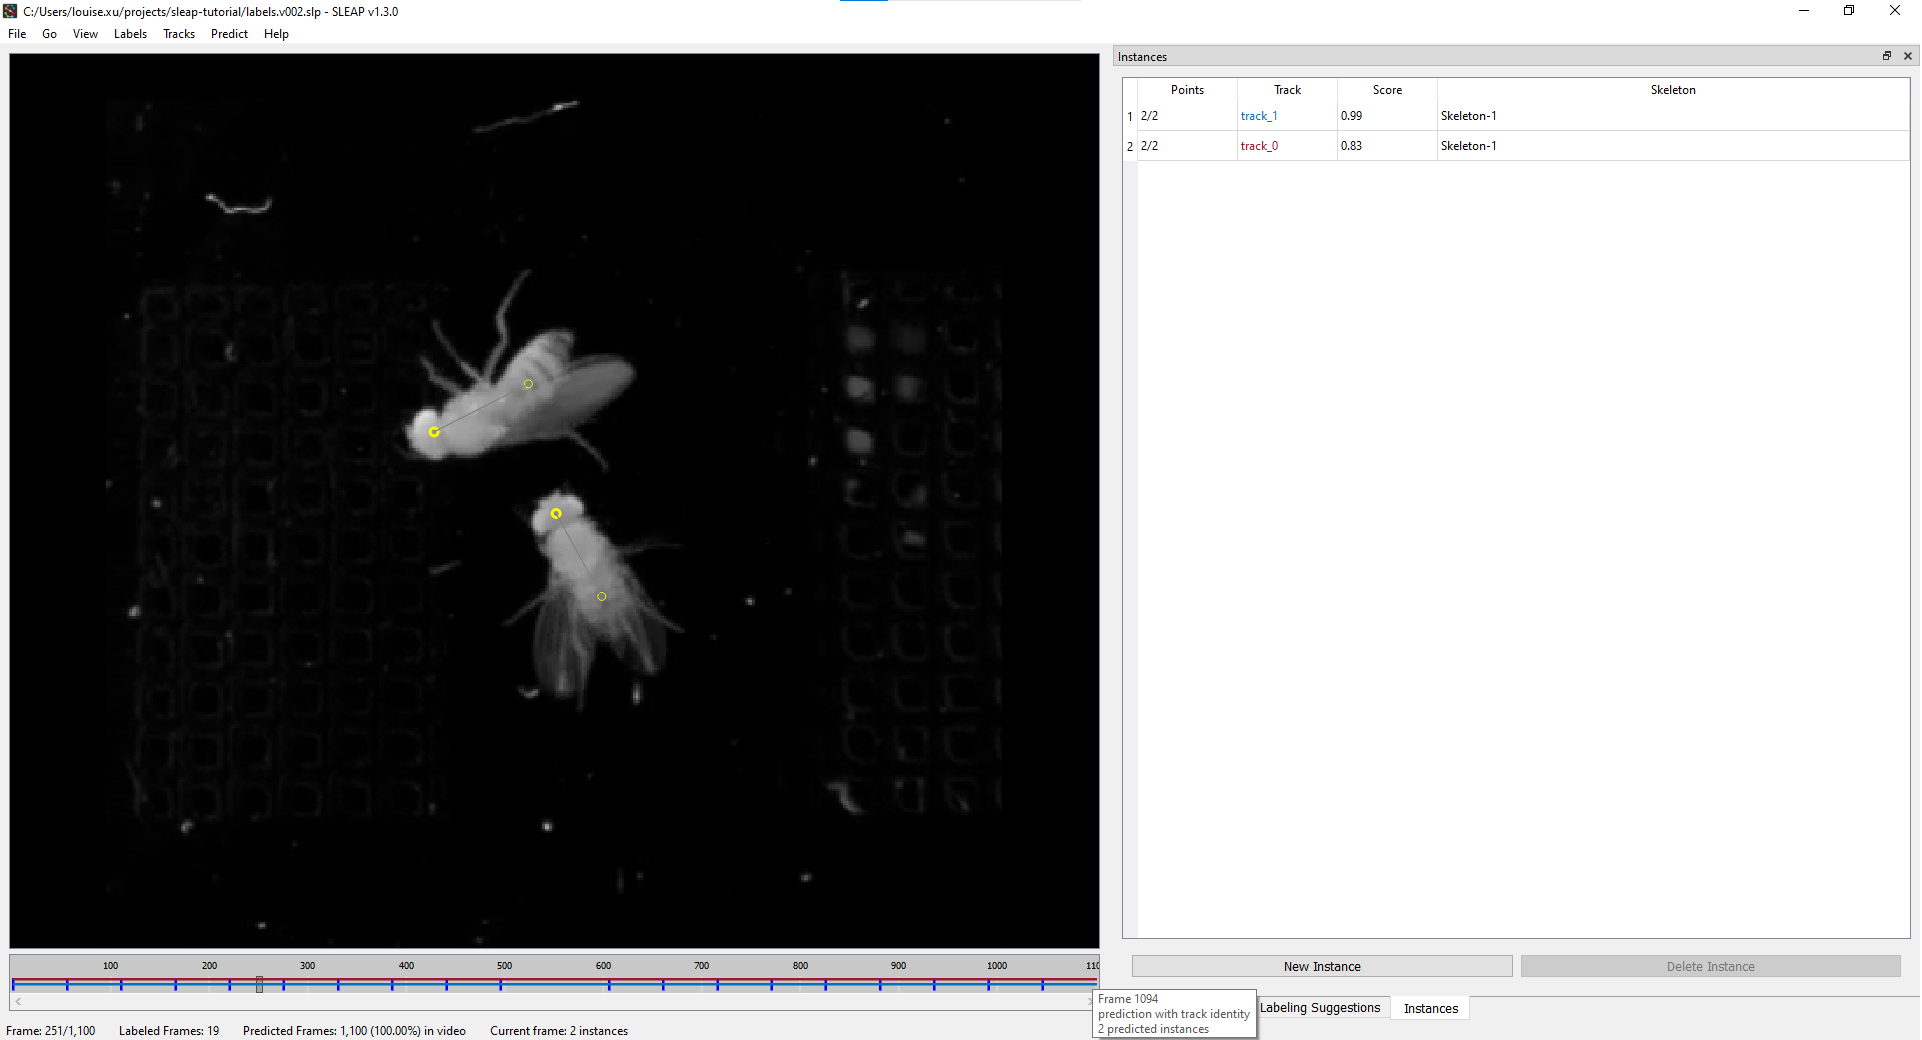


### 8. Proofread tracks

Once the user has the predicted tracks, the user will need to proofread these to ensure that the identities of instances across frames are correct. There are two main types of mistakes that can be made by the tracking code: mistaken identities and lost identities. There weren't any mistakes in this demo, but here are some instructions on what the user can do if they do occur. More detailed instructions are available at [the tutorial page](https://sleap.ai/develop/tutorials/proofreading.html). 

First, click "View - Color Predicted Instances" to show the tracks in color. The colors should match those in the seekbar and in the Instances panel. 

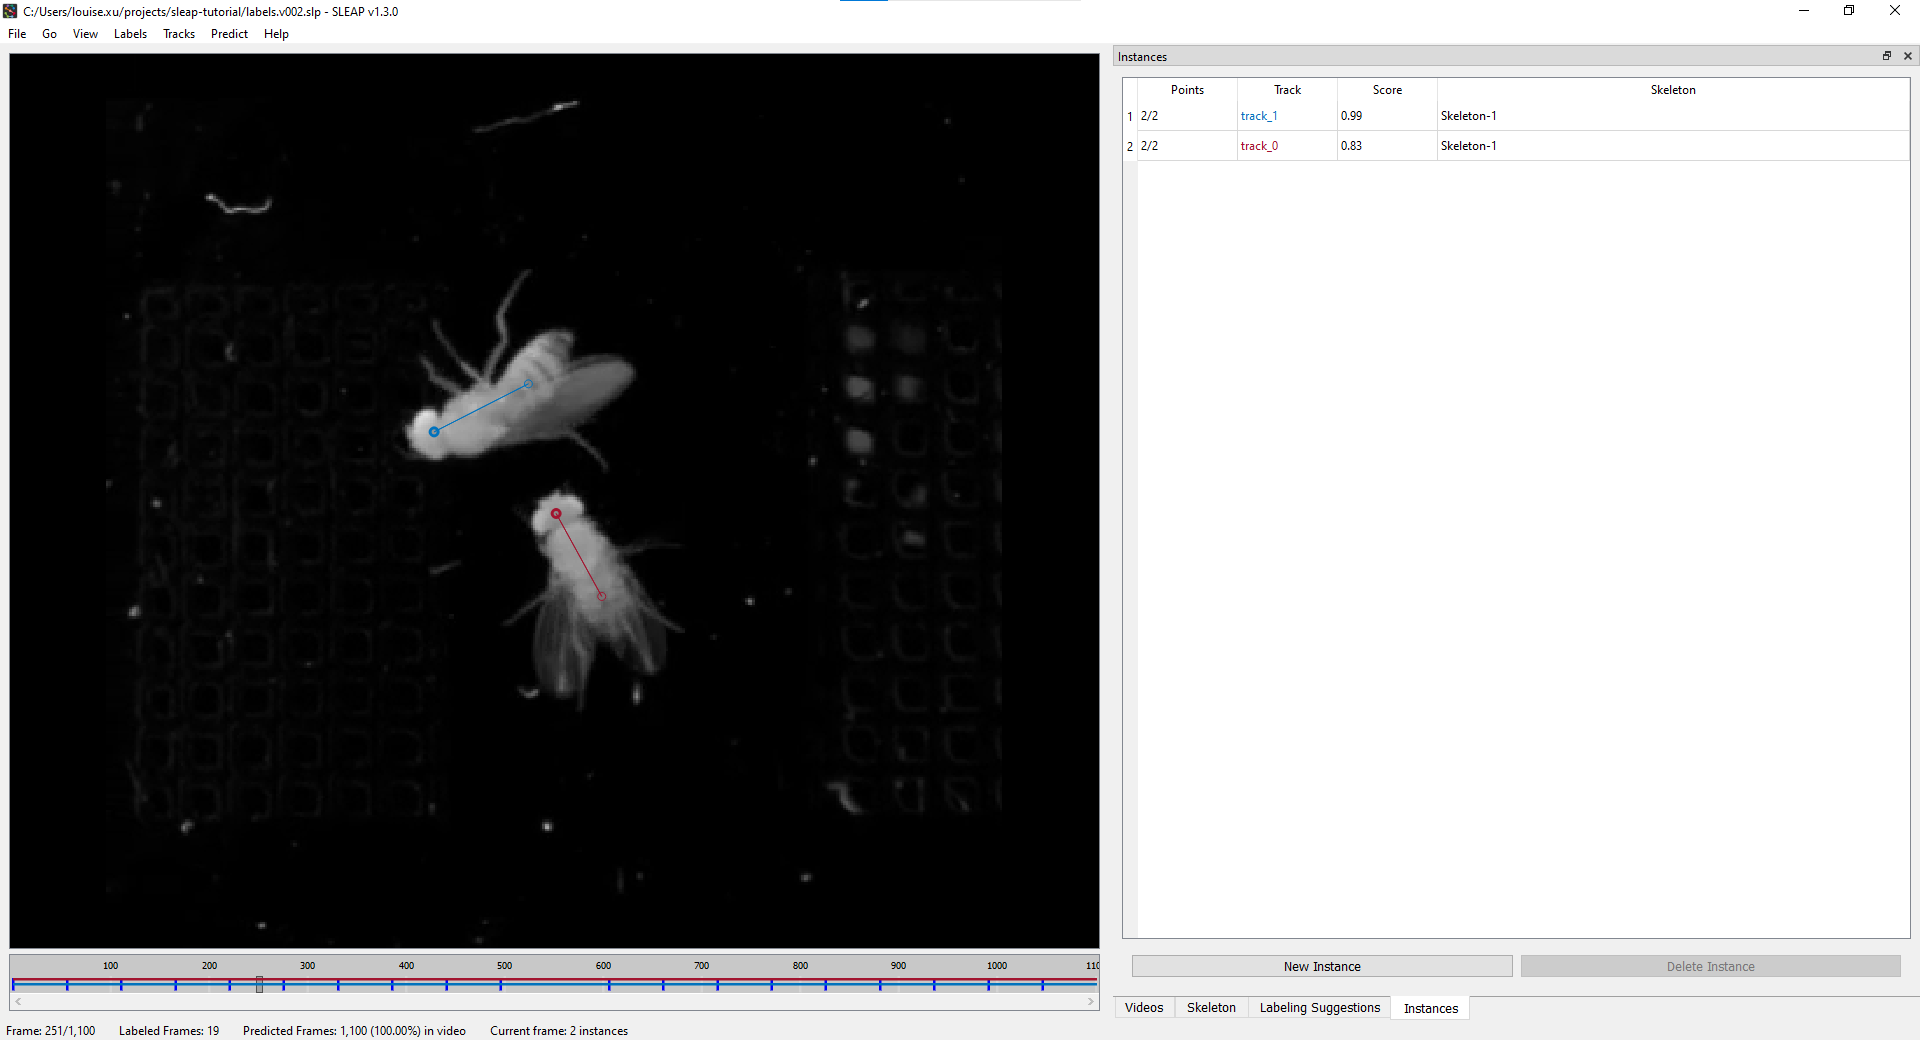

**Mistaken identities**

The code may misidentify which instance goes in which track, in which case the user will “swap” the track identities assigned to a pair of instances. Click "Tracks - Transpose Instance Tracks". Since there are only two instances for this demo, the swap is completed automatically. If there were more than 2 instances, the user would have to selected the two instances to be swapped. 

**Lost identities**

The code may fail to identity an instance in one frame with any instances from previous frames. Click "Go - Next Track Spawn Frame to go to the next frame in which a new track is spawned. Then manually change the instance track to the track from previous frames by going to "Tracks - Set Instance Track". 

### 9. Export data for analysis

The user will export SLEAP data from the video for further analysis in other software. 

Click "File - Export Analysis HDF5...". The HDF5 file can then be read into MATLAB and Python. This demo shows how to do it in Python, with more instructions available [here](https://sleap.ai/develop/tutorials/analysis.html). 

**Python**

===filename===
labels.v002.000_centered_pair_small.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations (tracks) data shape===
(1100, 2, 2, 2)

===nodes===
0: head
1: thorax



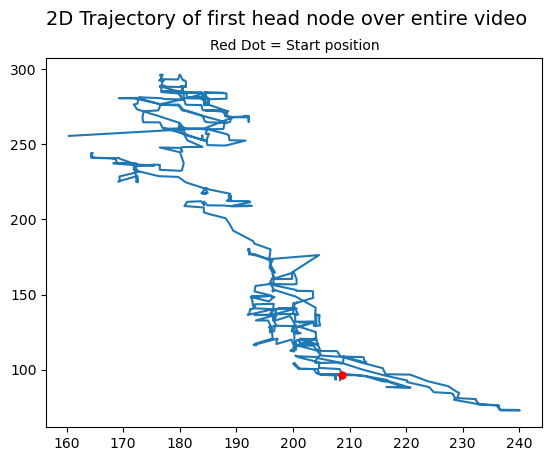

In [10]:
import h5py
import matplotlib.pyplot as plt

filename = 'labels.v002.000_centered_pair_small.analysis.h5' # or your own exported filename

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations (tracks) data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

head_locations = locations[:,0,0,:]
head_locations_x = head_locations[:,0]
head_locations_y = head_locations[:,1]
plt.plot(head_locations_x,head_locations_y)
plt.plot(head_locations_x[0],head_locations_y[0], color="red", markersize="5", marker="o")
plt.suptitle("2D Trajectory of first head node over entire video",fontsize=14)
plt.title("Red Dot = Start position", fontsize=10,y=1)

plt.show()